### Anti-body developability base model using original code

- Ref `https://huggingface.co/blog/ginkgo-datapoints/making-antibody-embeddings-and-predictions`

In [1]:
# Check for required packages in conda 'gigapath' environment
# To install missing packages, uncomment and run:
# !conda activate gigapath && conda install -y -c conda-forge datasets matplotlib numpy scipy seaborn scikit-learn pytorch tqdm transformers

import importlib
packages = ['datasets','matplotlib','numpy','scipy','seaborn','sklearn','torch','tqdm','transformers']
missing = []
for pkg in packages:
    if importlib.util.find_spec(pkg) is None:
        missing.append(pkg)
if missing:
    print('Missing packages:', missing)
else:
    print('All packages installed!')

Missing packages: ['datasets', 'matplotlib', 'numpy', 'scipy', 'seaborn', 'sklearn', 'torch', 'tqdm', 'transformers']


In [ ]:
# Install all required packages in one command
# !conda install -y -c conda-forge datasets matplotlib numpy scipy seaborn scikit-learn pytorch tqdm
# !pip install transformers>=4.32.0 --upgrade

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: linux-64
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done
Solving environment: done
done


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c defaults conda




==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/amomin/anaconda3/envs/hugging_py313

  added / updated specs:
    - datasets
    - matplotlib
    - numpy
    - pytorch
    - scikit-learn
    - scipy
    - seaborn
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aiohappyeyeballs-2.6.1     |     pyhd8ed1ab_0         

In [4]:
# Verify GPTNeoX is available
try:
    from transformers.models.gpt_neox import GPTNeoXForCausalLM
    print("GPTNeoX model available!")
except ImportError as e:
    print(f"GPTNeoX not available: {e}")

GPTNeoX model available!


In [1]:
## libraries

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer



/home/amomin/anaconda3/envs/hugging_py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "ollieturnbull/p-IgGen"
df = load_dataset("ginkgo-datapoints/GDPa1")["train"].to_pandas()

# Show number of NaNs per assay
print(df[["Titer", "HIC", "PR_CHO", "Tm2", 'AC-SINS_pH7.4']].isna().sum())
target = "HIC"

# Example: Just predict HIC, so we'll drop NaN rows for that
df = df.dropna(subset=[target])


Titer             7
HIC               4
PR_CHO           49
Tm2              53
AC-SINS_pH7.4     4
dtype: int64


In [3]:
## show dataframe
df.head()

,antibody_id,antibody_name,Titer,Purity,SEC %Monomer,SMAC,HIC,HAC,PR_CHO,PR_Ova,...,hc_protein_sequence,hc_dna_sequence,vl_protein_sequence,lc_protein_sequence,lc_dna_sequence,hierarchical_cluster_fold,random_fold,hierarchical_cluster_IgG_isotype_stratified_fold,light_aligned_aho,heavy_aligned_aho
0,GDPa1-001,abagovomab,140.25,98.530,97.010,2.730,2.590,NaN,0.337837,0.263108,...,MRAWIFFLLCLAGRALAQVKLQESGAELARPGASVKLSCKASGYTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQL...,MRAWIFFLLCLAGRALADIELTQSPASLSASVGETVTITCQASENI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,2,2,DIELTQSPASLSASVGETVTITCQAS--ENIY------SYLAWHQQ...,QVKLQES-GAELARPGASVKLSCKASG-YTFTN-----YWMQWVKQ...
1,GDPa1-002,abituzumab,193.31,99.825,97.620,2.745,2.545,3.690,0.205246,0.100155,...,MRAWIFFLLCLAGRALAQVQLQQSGGELAKPGASVKVSCKASGYTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQDI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,4,0,DIQMTQSPSSLSASVGDRVTITCRAS--QDIS------NYLAWYQQ...,QVQLQQS-GGELAKPGASVKVSCKASG-YTFSS-----FWMHWVRQ...
2,GDPa1-003,abrezekimab,114.75,98.350,89.055,2.740,2.705,NaN,0.138773,0.101180,...,MRAWIFFLLCLAGRALAQVTLKESGPVLVKPTETLTLTCTVSGFSL...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCLASEDISNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCLASEDI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,2,2,2,DIQMTQSPSSLSASVGDRVTITCLAS--EDIS------NYLAWYQQ...,QVTLKES-GPVLVKPTETLTLTCTVSG-FSLTN-----YHVQWIRQ...
3,GDPa1-004,abrilumab,327.32,98.575,98.605,2.715,2.565,1.005,0.000000,0.054971,...,MRAWIFFLLCLAGRALAQVQLVQSGAEVKKPGASVKVSCKVSGYTL...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSVSASVGDRVTITCRASQGI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,3,0,DIQMTQSPSSVSASVGDRVTITCRAS--QGIS------SWLAWYQQ...,QVQLVQS-GAEVKKPGASVKVSCKVSG-YTLSD-----LSIHWVRQ...
4,GDPa1-005,adalimumab,313.39,99.300,96.120,2.705,2.495,NaN,0.183387,0.085628,...,MRAWIFFLLCLAGRALAEVQLVESGGGLVQPGRSLRLSCAASGFTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQGI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,0,2,0,DIQMTQSPSSLSASVGDRVTITCRAS--QGIR------NYLAWYQQ...,EVQLVES-GGGLVQPGRSLRLSCAASG-FTFDD-----YAMHWVRQ...


In [4]:
# Tokenize the sequences
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Paired sequence handling: Concatenate heavy and light chains and add beginning ("1") and end ("2") tokens
# (e.g. ["EVQLV...", "DIQMT..."] -> "1E V Q L V ... D I Q M T ... 2")
sequences = [
    "1" + " ".join(heavy) + " ".join(light) + "2"
    for heavy, light in zip(
        df["vh_protein_sequence"],
        df["vl_protein_sequence"],
    )
]

print(sequences[0])


1Q V K L Q E S G A E L A R P G A S V K L S C K A S G Y T F T N Y W M Q W V K Q R P G Q G L D W I G A I Y P G D G N T R Y T H K F K G K A T L T A D K S S S T A Y M Q L S S L A S E D S G V Y Y C A R G E G N Y A W F A Y W G Q G T T V T V S SD I E L T Q S P A S L S A S V G E T V T I T C Q A S E N I Y S Y L A W H Q Q K Q G K S P Q L L V Y N A K T L A G G V S S R F S G S G S G T H F S L K I K S L Q P E D F G I Y Y C Q H H Y G I L P T F G G G T K L E I K2


In [5]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
).to(device)

# Takes about 60 seconds for 242 sequences on my CPU, and 1.1s on GPU
batch_size = 16
mean_pooled_embeddings = []
for i in tqdm(range(0, len(sequences), batch_size)):
    batch = tokenizer(sequences[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
    outputs = model(batch["input_ids"].to(device), return_rep_layers=[-1], output_hidden_states=True)
    embeddings = outputs["hidden_states"][-1].detach().cpu().numpy()
    mean_pooled_embeddings.append(embeddings.mean(axis=1))
mean_pooled_embeddings = np.concatenate(mean_pooled_embeddings)


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


In [6]:
# Train a linear regression on these
X = mean_pooled_embeddings
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = Ridge()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)


SignificanceResult(statistic=np.float64(0.4132986409842702), pvalue=np.float64(0.003161196522793317))


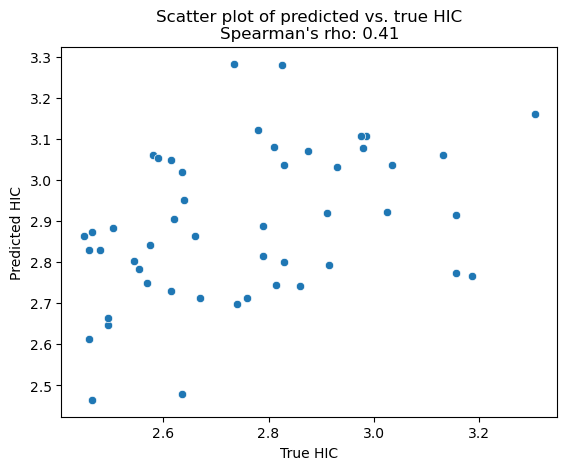

In [7]:
# Calculate score
print(spearmanr(y_pred, y_test))

sns.scatterplot(x=y_test, y=y_pred)
plt.title(f"Scatter plot of predicted vs. true {target}\nSpearman's rho: {spearmanr(y_pred, y_test)[0]:.2f}")
plt.xlabel(f"True {target}")
plt.ylabel(f"Predicted {target}")
plt.show()


Fold	N	Spearman_rho
0	53	0.0810
1	48	0.2882
2	48	0.4557
3	44	0.4333
4	49	0.4089
Overall (all folds)	242	0.3241


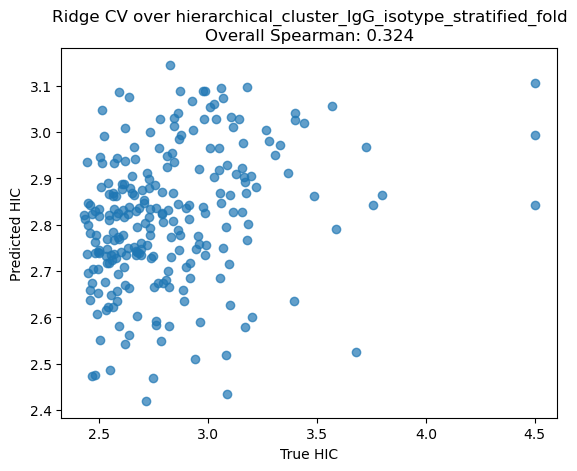

In [8]:
fold_col = "hierarchical_cluster_IgG_isotype_stratified_fold"
X = mean_pooled_embeddings
y = df[target].to_numpy(dtype=float)

# sanity check
assert len(X) == len(df) == len(y)

fold_values = df[fold_col].to_numpy()
unique_folds = [f for f in np.unique(fold_values) if f == f]  # drop NaN

per_fold_stats = []
y_pred_all = np.full(len(df), np.nan)   # align with df rows
y_true_all = np.full(len(df), np.nan)   # optional, for plotting/metrics

for f in unique_folds:
    test_idx = np.where(fold_values == f)[0]
    train_idx = np.where(fold_values != f)[0]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    lm = Ridge()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)

    # write back into the positions of df
    y_pred_all[test_idx] = y_pred
    y_true_all[test_idx] = y_test

    rho = spearmanr(y_test, y_pred).statistic
    per_fold_stats.append((int(f), rho, len(y_test)))

# Overall metric across all rows that participated in CV
mask = ~np.isnan(y_true_all)
overall_rho = spearmanr(y_true_all[mask], y_pred_all[mask]).statistic

print("Fold\tN\tSpearman_rho")
for f, rho, n in per_fold_stats:
    print(f"{f}\t{n}\t{rho:.4f}")
print(f"Overall (all folds)\t{mask.sum()}\t{overall_rho:.4f}")

plt.figure()
plt.scatter(y_true_all[mask], y_pred_all[mask], alpha=0.7)
plt.title(f"Ridge CV over {fold_col}\nOverall Spearman: {overall_rho:.3f}")
plt.xlabel(f"True {target}")
plt.ylabel(f"Predicted {target}")
plt.show()


In [9]:
GDPa_submission_CV  =  df[['antibody_name', 'vh_protein_sequence', 'vl_protein_sequence', 'hierarchical_cluster_IgG_isotype_stratified_fold']].copy()
GDPa_submission_CV[target] =  y_pred_all
GDPa_submission_CV.to_csv('gpda_cv_submission.csv', index=False)


In [10]:
### download the test data and predict model performance

# load from csv
testset_df  =  pd.read_csv('heldout-set-sequences.csv')

# make sequences
testset_sequences = [
    "1" + " ".join(heavy) + " ".join(light) + "2"
    for heavy, light in zip(
        testset_df["vh_protein_sequence"],
        testset_df["vl_protein_sequence"],
    )
]

# make embeddings
testset_embeddings = []
for i in tqdm(range(0, len(testset_sequences), batch_size)):
    batch = tokenizer(
        testset_sequences[i:i+batch_size],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    outputs = model(
        batch["input_ids"].to(device),
        return_rep_layers=[-1],
        output_hidden_states=True,
    )
    embeddings = outputs["hidden_states"][-1].detach().cpu().numpy()
    testset_embeddings.append(embeddings.mean(axis=1))

testset_embeddings = np.concatenate(testset_embeddings)


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


In [11]:
## write the test prediction output 

X  =  testset_embeddings
testset_y  =  lm.predict(X)
testset_submission  =  testset_df[['antibody_name', 'vh_protein_sequence', 'vl_protein_sequence']].copy()

testset_submission[target] =  testset_y

testset_submission.to_csv('testset_submission.csv', index=False)
